In [1]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
from IPython.display import Audio
import numpy as np
import pandas as pd
import pickle
import yaml

from lib.notebooks import plot_groups_metrics
from communicative_agent import CommunicativeAgent

In [2]:
agents_path = glob("../out/communicative_agent/*/")
agents_path.sort()

In [3]:
groups_metrics = {}
agents_loss = {
    "path": [],
    "datasets": [],
    "inverse_learning_rate": [],
    "inverse_layers": [],
    "inverse_dropout_p": [],
    "direct_learning_rate": [],
    "direct_layers": [],
    "direct_dropout_p": [],
    "jerk_weight": [],
    "direct_estimation_error": [],
    "inverse_estimation_error": [],
    "jerk": [],
    "repetition_error": [],
}

for agent_path in agents_path:
    agent = CommunicativeAgent.reload(agent_path, load_nn=False)
    config = agent.config
    with open("%s/metrics.pickle" % agent_path, "rb") as f:
        metrics = pickle.load(f)
    
    agents_loss["path"].append(agent_path[-5:-1])
    agents_loss["datasets"].append(",".join(agent.sound_quantizer.config['dataset']['names']))

    agents_loss["inverse_learning_rate"].append(config['training']['inverse_model_learning_rate'])
    agents_loss["inverse_layers"].append(f"{config['model']['inverse_model']['num_layers']}x{config['model']['inverse_model']['hidden_size']}")
    agents_loss["inverse_dropout_p"].append(config['model']['inverse_model']['dropout_p'])

    if 'use_synth_as_direct_model' not in config['model']:
        agents_loss["direct_learning_rate"].append(config['training']['direct_model_learning_rate'])
        agents_loss["direct_layers"].append(f"{len(config['model']['direct_model']['hidden_layers'])}x{config['model']['direct_model']['hidden_layers'][0]}")
        agents_loss["direct_dropout_p"].append(config['model']['direct_model']['dropout_p'])
    else:
        agents_loss["direct_learning_rate"].append(0)
        agents_loss["direct_layers"].append("synth")
        agents_loss["direct_dropout_p"].append(0)
    
    agents_loss["jerk_weight"].append(config['training']['jerk_loss_weight'])

    final_loss_index = np.argmin(metrics["validation"]["inverse_model_repetition_error"])
    
    
    if 'use_synth_as_direct_model' not in config['model']:
        agents_loss["direct_estimation_error"].append(metrics["test"]["direct_model_estimation_error"][final_loss_index])
    else:
        agents_loss["direct_estimation_error"].append(0)

    agents_loss["inverse_estimation_error"].append(metrics["test"]["inverse_model_estimation_error"][final_loss_index])
    agents_loss["jerk"].append(metrics["test"]["inverse_model_jerk"][final_loss_index])
    agents_loss["repetition_error"].append(metrics["test"]["inverse_model_repetition_error"][final_loss_index])
    
    group_name = "\n".join((
        f"datasets={','.join(agent.sound_quantizer.config['dataset']['names'])}",
        f"synth_art={agent.synthesizer.config['dataset']['art_type']}",
        f"jerk_w={config['training']['jerk_loss_weight']}",
        # f"frame_padding={config['model']['sound_quantizer']['frame_padding']}",
    ))
    
    if group_name not in groups_metrics:
        groups_metrics[group_name] = {}
    groups_metrics[group_name][agent_path] = metrics

agents_loss = pd.DataFrame(agents_loss)

In [4]:
datasets = pd.unique(agents_loss["datasets"])
jerk_weights = pd.unique(agents_loss["jerk_weight"])

def show_top_agents(measure="repetition_error", datasets=datasets[0], jerk_weight=jerk_weights[0], use_synth_as_direct=False, ascending=True):
    subset = agents_loss[agents_loss["datasets"] == datasets]
    subset = subset[subset["jerk_weight"] == jerk_weight]
    if use_synth_as_direct:
        subset = subset[subset["direct_layers"] == "synth"]
    else:
        subset = subset[subset["direct_layers"] != "synth"]
    display(subset.sort_values(measure, ascending=ascending).head(30))

ipw.interactive(show_top_agents, measure=agents_loss, datasets=datasets, jerk_weight=jerk_weights, use_synth_as_direct=False, ascending=True)

interactive(children=(Dropdown(description='measure', index=12, options=('path', 'datasets', 'inverse_learning…

interactive(children=(Dropdown(description='split_name', index=2, options=('train', 'validation', 'test'), val…

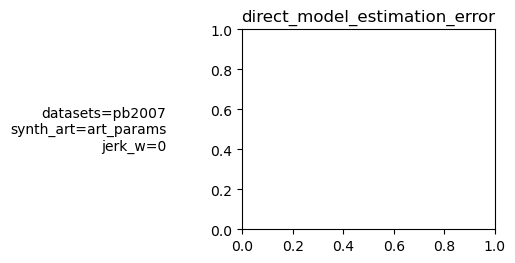

In [5]:
metrics_name = [
    # "sound_quantizer_reconstruction_error",
    # "sound_quantizer_vq_loss",
    "direct_model_estimation_error",
    "inverse_model_estimation_error",
    "inverse_model_repetition_error",
    "inverse_model_jerk",
]

def show_metrics(split_name="test"):
    plot_groups_metrics(groups_metrics, metrics_name, split_name)
display(ipw.interactive(show_metrics, split_name=["train", "validation", "test"]))